In [1]:
import cv2
import os
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

## Importing libraries and reading dataset

In [2]:
data_path = 'datasets/'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))  
print(label_dict)
print(categories)
print(labels)

{'no': 0, 'yes': 1}
['no', 'yes']
[0, 1]


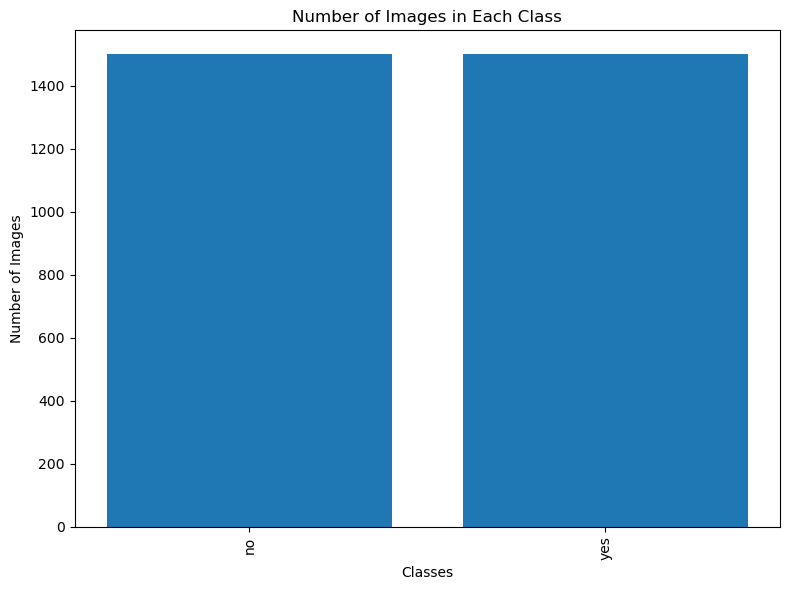

In [3]:
import os
import matplotlib.pyplot as plt

class_counts = {}

for category in categories:
    class_path = os.path.join(data_path, category)
    num_images = len(os.listdir(class_path))
    class_counts[category] = num_images

plt.figure(figsize=(8, 6))  # Increase the figure width
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of Images in Each Class')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)  # Increase rotation angle for better alignment
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Resizing and converting images into greyscale

In [4]:
img_size = 224
data = []
label = []

for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            # resizing the image into 224x224, as required by ResNet50
            data.append(resized)
            label.append(label_dict[category])
            # appending the image and the label(categorized) into the list (dataset)
        except Exception as e:
            print('Exception:', e)
            # if any exception raised, the exception will be printed here. And pass to the next image

In [5]:
data = np.array(data) / 255.0
data = np.stack((data,) * 3, axis=-1)  # stack grayscale images to create 3 channels
label = np.array(label)

In [6]:
data.shape

(3000, 224, 224, 3)

## Splitting dataset into testing and training

In [7]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

In [8]:
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_test shape: (600, 224, 224, 3)
y_test shape: (600,)


## Plotting sample of images

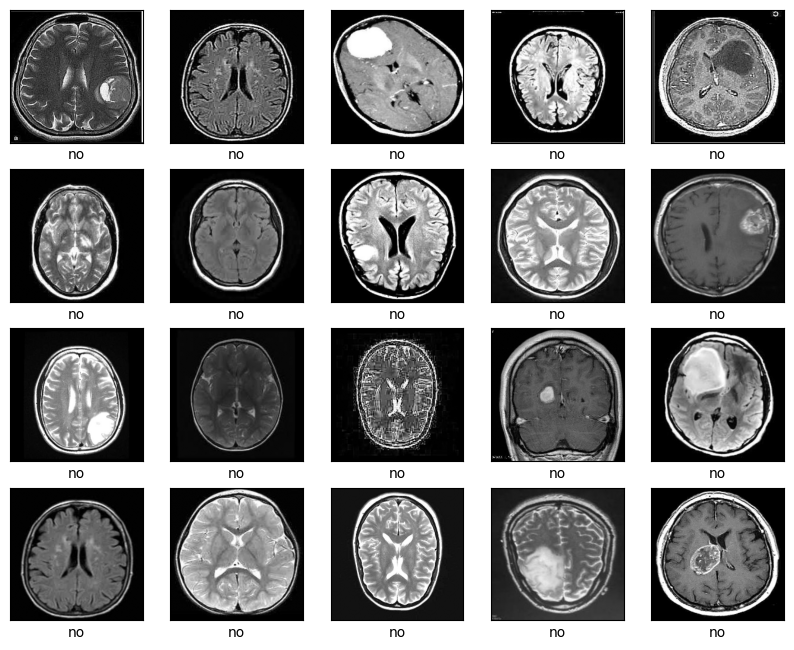

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_test[i]))
    plt.xlabel(categories[np.argmax(y_test[i])])
plt.show()

## VGG16

In [10]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers in the base VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Create the model architecture
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Use 'sigmoid' for binary classification

# Define the input and output of the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define model checkpoint callback to save the best model during training
checkpoint = ModelCheckpoint("vgg16_model.h5", monitor='val_loss', save_best_only=True)

# Train the model with early stopping and model checkpoint callbacks
history_vgg = model.fit(x_train, y_train, 
                        batch_size=32, 
                        epochs=10, 
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, checkpoint])

Epoch 1/10
60/60 [==============================] - 230s 4s/step - loss: 0.5518 - accuracy: 0.7359 - val_loss: 0.3729 - val_accuracy: 0.8125
Epoch 2/10


C:\Users\mohdh\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 260s 4s/step - loss: 0.2824 - accuracy: 0.8813 - val_loss: 0.2174 - val_accuracy: 0.9229
Epoch 3/10
60/60 [==============================] - 276s 5s/step - loss: 0.1681 - accuracy: 0.9312 - val_loss: 0.1192 - val_accuracy: 0.9750
Epoch 4/10
60/60 [==============================] - 306s 5s/step - loss: 0.1078 - accuracy: 0.9661 - val_loss: 0.0896 - val_accuracy: 0.9688
Epoch 5/10
60/60 [==============================] - 303s 5s/step - loss: 0.0690 - accuracy: 0.9802 - val_loss: 0.0647 - val_accuracy: 0.9896
Epoch 6/10
60/60 [==============================] - 302s 5s/step - loss: 0.0356 - accuracy: 0.9927 - val_loss: 0.1032 - val_accuracy: 0.9688
Epoch 7/10
60/60 [==============================] - 302s 5s/step - loss: 0.0387 - accuracy: 0.9870 - val_loss: 0.0646 - val_accuracy: 0.9854
Epoch 8/10
60/60 [==============================] - 303s 5s/step - loss: 0.0274 - accuracy: 0.9927 - val_loss: 0.0628 - val_accuracy: 0.9896
Epoch 9/10
60/60 [======

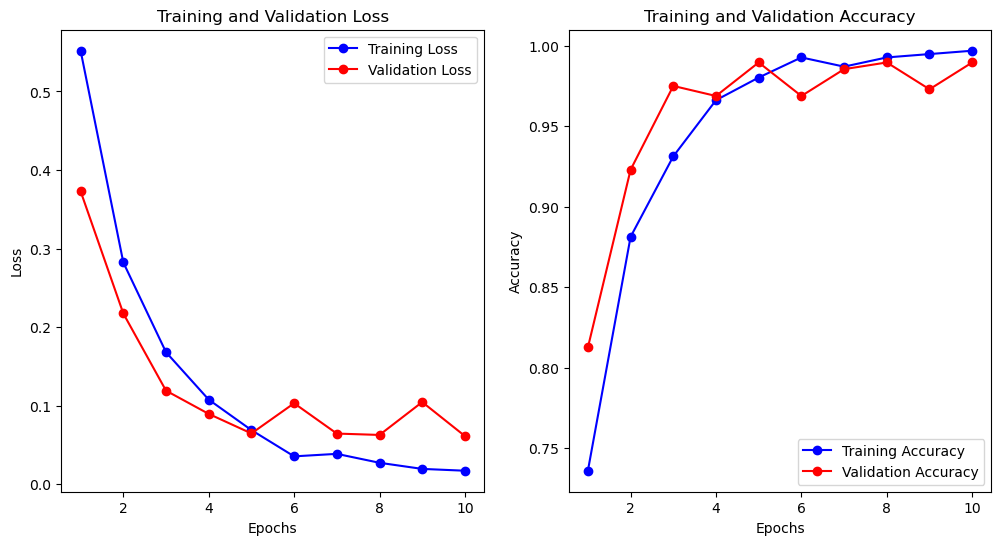

In [13]:
# Learning Curve
train_loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
train_accuracy = history_vgg.history['accuracy']
val_accuracy = history_vgg.history['val_accuracy'] 
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import numpy as np

train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=1) 
train_predictions = (model.predict(x_train) > 0.5).astype("int32").flatten()
val_predictions = (model.predict(x_val) > 0.5).astype("int32").flatten()
test_predictions = (model.predict(x_test) > 0.5).astype("int32").flatten()

19/19 [==============================] - 73s 4s/step


In [15]:
train_f1 = f1_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)
train_accuracy = accuracy_score(y_train, train_predictions)

val_f1 = f1_score(y_val, val_predictions)
val_precision = precision_score(y_val, val_predictions)
val_recall = recall_score(y_val, val_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

test_f1 = f1_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

In [16]:
# Print results
# print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)
print("Training F1 Score:", train_f1)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)

# Print validation metrics
print("\nValidation Accuracy:", val_accuracy)
print("Validation F1 Score:", val_f1)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)

# Print test metrics
print("\nTest Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Training Accuracy: 0.9989583333333333
Training F1 Score: 0.9989806320081549
Training Precision: 0.9979633401221996
Training Recall: 1.0

Validation Accuracy: 0.9895833333333334
Validation F1 Score: 0.9892933618843683
Validation Precision: 0.9871794871794872
Validation Recall: 0.9914163090128756

Test Accuracy: 0.9783333333333334
Test F1 Score: 0.9777777777777777
Test Precision: 0.959731543624161
Test Recall: 0.9965156794425087


In [17]:
y_pred = model.predict(x_test)
# Convert predicted probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

19/19 [==============================] - 74s 4s/step


In [18]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[301  12]
 [  1 286]]


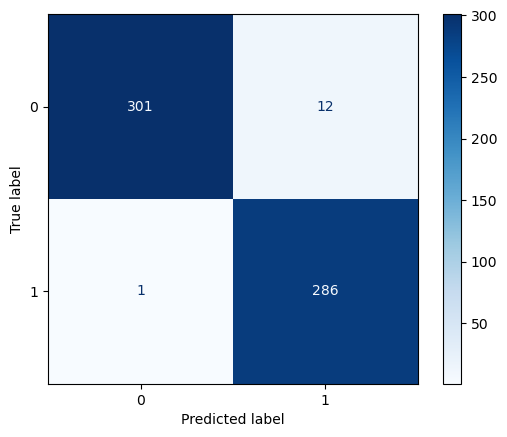

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [20]:
from keras.models import load_model
model_loaded = load_model('vgg16_model.h5')

In [21]:
# Load and preprocess the new image
image_folder = 'datasets/no'
image_name = 'no20.jpg'
image_path = os.path.join(image_folder, image_name)

new_image = cv2.imread(image_path)
new_image = cv2.resize(new_image, (224, 224))  # Resize to match the input size of your model
new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
new_image = new_image.astype(np.float32) / 255.0  # Normalize pixel values

new_image = np.expand_dims(new_image, axis=0)

# Make predictions
prediction = model.predict(new_image)

# Interpret the prediction
if prediction[0, 0] > 0.5:
    print('The model predicts that the image contains a tumor.')
else:
    print('The model predicts that the image does not contain a tumor.')

1/1 [==============================] - 0s 141ms/step
The model predicts that the image does not contain a tumor.
